# Project - deep learning modeling and optimization

#### Student: Doron Sananes
In this project you'll be required to implement an architecture of a network, train it on dataset while comparing different optimizers and eventually optimize it using TensorRT.



## Part A: tensorflow  training for CIFAR-100

In this part I implemented Convolutional neural networks (CNN) architecture in tensorflow and train it using the CIFAR-100 dataset 

While training i a have used different CNN architectures, I performed model evaluation, compared the accurency and loss results and saved the the best model to S3.
I have add explinations for each step during my work


# How to build a ConvNet for CIFAR-100 classification with Keras?
https://www.machinecurve.com/index.php/2020/02/09/how-to-build-a-convnet-for-cifar-10-and-cifar-100-classification-with-keras/#image-datasets-the-cifar-10-and-cifar-100-datasets

## 1. Convolutional Neural Networks (CNN)
Convolutional neural networks are great tools for building image classifiers. They have been used thoroughly since the 2012 deep learning breakthrough, and have led to interesting applications such as classifiers and object detectors.

## 2. Why Convolutional Neural Networks suit image classification ?

### CNN Decomposition of images into smaller, generic parts
1. Our brain decomposes (or “breaks down”) the image it sees into smaller parts.
2. These parts, in return, take some kind of “generic shape”. 
3. We thus instantly recognize it as the “bottom part”, regardless of the precise shape it takes.

Now, convolutional neural networks, together with extra additions such as pooling layers, attempt to mimic this process. They break down input images into smaller parts in ways they have learnt during training. Preferably, these smaller parts are “generic”, so that a wide range of input data should yield the same conclusion. 

## 3. How a convolutional layer works
The input to CIFAR-100 convolutional layer is a 32×32 image, the height and the width of the images. 
These days, most images are RGB – red, green and blue – and hence we have 3 image channels. 

Now, the convolutional layer works with N(which is 5 x 5 pixels in the schematic drawing below) so called “kernels”. 

The value for N can be configured by the machine learning engineer. 
These kernels, which have a fixed Hkernel and Wkernel that are often much smaller than the input (e.g. 3×3), have the same amount of channels as the input data.

They are initialized with “weights”, and this is what makes learning possible .


Now, this “kernel” (which is 3 x 3 pixels) slides (or “convolves”) over the input data. 
In doing so, for each position it takes, it multiplies the w
eight at some point with the corresponding pixel in your input data, element-wise. This means that all the individual multiplications are added together, and that the output of that particular kernel-input multiplication is 1 pixel:

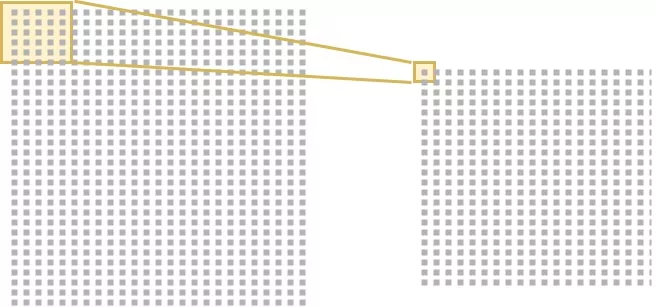

Now, sliding over the entire image horizontally and vertically, it produces many of such “outputs” – rendering the output on the right in the image above. This output, which is called a “feature map”, is smaller than the input data, and essentially contains the input data in a more “abstract” fashion. Now, as there are N kernels, there will be N such feature maps produced by a convolutional layer.

#### Feature detection and the “smaller parts”
The fun thing, here, is that the network can be trained. That is, the weights can be adapted. During this training process, the network as a whole will produce one output value. This output value can be compared to the true target – a.k.a. the “ground truth”. The difference between the two can be captured in a loss value that can subsequently be used for optimizing the model. This way, iteratively, the model can learn weights that yield the most optimal outputs.

#### Adding Pooling to make the parts generic
Similar to convolutional layers, pooling layers slide over the inputs, but instead of multiplying the parts with some learnt weights, they compute a hard value such as max().

Pooling substantially reduces the size of your feature map, and in this case takes the maximum value
Means:
1. The most important feature in the feature map will be used. 
As the convolutional layer directly in front of the pooling layer will likely learn to detect the object(s) of interest, this is likely the object we want to detect.
2. It does not matter in which of the four red positions the object is present; it will always be taken along into the pooling layer’s output.

This way, we introduce “feature invariance” into the model. Together, the convolutional layer both “learns parts” and “learns them in a generic way”

# the  CIFAR-100 datasets

## CIFAR-100
The CIFAR-100 dataset consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images.
CIFAR-100 are grouped into 20 superclasses

Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

    'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),


## Prepare environment
read the notebook & dataset from S3

In [3]:
#copy from s3
#!aws s3 cp  s3://uatt-e1-dorons/FinalProject3/project3-cifar100-model.ipynb ./project3-cifar100-model.ipynb

In [4]:
#!aws s3 sync s3://uatt-e1-dorons/FinalProject3/data_cifar100 ./data_cifar100

In [5]:
#!pip install --upgrade pip

In [6]:
#!pip install -q tfds-nightly tensorflow matplotlib

In [7]:
#!pip install tensorflow_datasets

In [8]:
#!pip install pandas

## Import Libraries

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas

## Browsing tensorflow_datasets
TensorFlow Datasets is a collection of datasets ready to use, with TensorFlow or other Python ML frameworks,

In [6]:
#tfds.list_builders()

## Uploading CIFAR-100 nad split it to train and test

### Large datasets
Large datasets are sharded (split in multiple files), and typically do not fit in memory so they should not be cached.

### Shuffle and training
During training, it's important to shuffle the data well; poorly shuffled data can result in lower training accuracy.

In addition to using ds.shuffle to shuffle records, you should also set shuffle_files=True to get good shuffling behavior for larger datasets that are sharded into multiple files. Otherwise, epochs will read the shards in the same order, and so data won't be truly randomized.

### Auto-shard your data across workers
When training on multiple workers, you can use the input_context argument of tfds.ReadConfig, so each worker will read a subset of the data.


### as_supervised	bool
if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label) according to builder.info.supervised_keys. If False, the default, the returned tf.data.Dataset will have a dictionary with all the features.

### batch_size	int
if set, add a batch dimension to examples. Note that variable length features will be 0-padded. If batch_size=-1, will return the full dataset as tf.Tensors.

### data_dir	str
directory to read/write data. Defaults to the value of the environment variable TFDS_DATA_DIR, if set, otherwise falls back to '~/tensorflow_datasets'.

## laoding dataset

In [7]:
#split train 80% to train (40K), 20% for validation (10K)
#test for test (10K)
tf.compat.v1.enable_eager_execution()
(train, val, test), info = tfds.load('cifar100', split=['train[:80%]', 'train[80%:]', 'test'],  
                                        shuffle_files=True, 
                                        with_info=True,
                                        as_supervised=True,
                                        data_dir='./data_cifar100')


## print samples

,image,label
0,,66 (raccoon)
1,,23 (cloud)

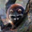
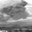

In [8]:
tfds.as_dataframe(train.take(2), info)

In [9]:
print ('train len=', len(train))
print ('test len=', len(test))
print ('val len=', len(val))

train len= 40000
test len= 10000
val len= 10000


In [10]:

train

<_OptionsDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>

## Build model Function

## Creating the model architecture
We can then create the architecture of our model. 
1. First, we’ll instantiate the Sequential API and assign it to model: this is like the foundation of your model, the Lego board onto which you can “click” bricks, a.k.a. layers.


2. Next, it’s time to stack a few layers. 
    2.1 Firstly, we’ll use three convolutional blocks – which is the nickname I often use for convolutional layers with some related ones. In this case, the related layer that is applied every time is a MaxPooling2D one directly after the Conv2D layer. As you can see, each time, the numer of feature maps increases – from 32, to 64, to 128. This is done because the model then learns a limited number of “generic” patterns (32) and a high amount of patterns unique to the image (128). Max Pooling ensures translation invariance, as we discussed before.


3. After the convolutional blocks, we add a Flatten layer. The Dense layers, which are responsible for generating the actual classifications, only work with one-dimensional data. Flatten makes this happen: it converts the multidimensional feature maps into one-dimensional shape. Great!


4. As said, the Dense layers ensure that classification is possible. As you can see, in terms of the number of outputs per layer, we create an information bottleneck that eventually converges in no_classes – thus 100 – outputs, exactly the number of unique classes in our dataset. As we’re using the Softmax activation function, we’ll get a discrete multiclass probability distribution as our output for any input. From this distribution, we can draw the one with the highest value, which is the most likely class for our input. 

## Compiling the model & fitting data
1.  What we did so far was create the skeleton for our model. We don’t have a model yet, as it must be compiled first. This can be done by calling model.compile. As you can see, it involves specifying settings for the training process, such as the loss function and the optimizer. What’s more, and what I always prefer, is to add accuracy as an additional metric, due to it being intuitive for humans.


2. Once the model is compiled, we do have a model, but it’s not yet trained. We can start the training process by calling model.fit, which fits our data (in this case our training data and the corresponding targets) and specifies some settings for our training process, ones that we configured before.


3. Here, it also becomes clear why we decided to use sparse categorical crossentropy instead of true categorical crossentropy. Categorical crossentropy requires our data to be categorical, which can e.g. be achieved with to_categorical i.e. one-hot encoding of your target vectors.

4. Our data is not categorical by nature: our targets are integers in the range [0,99]. But why convert them, I’d argue, if there is a loss function which does the same as true categorical crossentropy but works with integer targets? Indeed, sparse categorical crossentropy is this activation function. Hence, we choose it over the other one 🙂



#### from_logits=True

The  attribute inform the loss function that the output values generated by the model are not normalized, a.k.a. logits. In other words, the softmax function has not been applied on them to produce a probability distribution. Therefore, the output layer in this case does not have a softmax activation function:

out = tf.keras.layers.Dense(n_units)  # <-- linear activation function
The softmax function would be automatically applied on the output values by the loss function. Therefore, this does not make a difference with the scenario when you use from_logits=False (default) and a softmax activation function on last layer; however, in some cases, this might help with numerical stability during training of the model. You may also find this and this answers relevant and useful about the numerical stability when from_logits=True.

##### bottem line:
basically what it means is if softmax layer is not being added at the last layer then we need to have the from_logits=True to indicate the probabilities are not normalized 

In [11]:

def build_model_1(lr):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(100, activation='softmax'),
    
    ]) 
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    return model



In [12]:


# define cnn model
def build_model_2(lr):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
       
       
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(100, activation='softmax'),
    
    ]) 


    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    return model



In [13]:

def build_model_3(lr):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
       
       
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(100, activation='softmax'),
    
    ]) 


    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    return model


In [14]:
from tensorflow.keras.initializers import he_normal
def build_model_vgg19(lr):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_initializer=he_normal(), padding='same', input_shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_initializer=he_normal(), padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
     
        
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu',kernel_initializer=he_normal(), padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu',kernel_initializer=he_normal(), padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
     
        
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu',kernel_initializer=he_normal(), padding='same'),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu',kernel_initializer=he_normal(), padding='same'),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu',kernel_initializer=he_normal(), padding='same'),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu',kernel_initializer=he_normal(), padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      

        tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu',kernel_initializer=he_normal(), padding='same'),
        tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu',kernel_initializer=he_normal(), padding='same'),
        tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu',kernel_initializer=he_normal(), padding='same'),
        tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu',kernel_initializer=he_normal(), padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu',kernel_initializer=he_normal(), padding='same'),
        tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu',kernel_initializer=he_normal(), padding='same'),
        tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu',kernel_initializer=he_normal(), padding='same'),
        tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu',kernel_initializer=he_normal(), padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

       
        tf.keras.layers.Flatten(),

        
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(100, activation='softmax'),
    
    ]) 

    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    
    return model

## Train model function

### EarlyStopping in Keras
 monitor="val_loss", 
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    
monitor: Quantity to be monitored.
min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.

patience: Number of epochs with no improvement after which training will be stopped.

verbose: verbosity mode.

mode: One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.

baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.

restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used. An epoch will be restored regardless of the performance relative to the baseline. If no epoch improves on baseline, training will run for patience epochs and restore weights from the best epoch in that set.

In [15]:

def train_model(model, epochs):
    train_batch = train.shuffle(1024).repeat(repeatOnEpoch).batch(numberOfBatchs).prefetch(tf.data.experimental.AUTOTUNE)
    val_batch = test.shuffle(1024).batch(numberOfBatchs).prefetch(tf.data.experimental.AUTOTUNE)
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
        
    #early stopping to monitor the validation loss and avoid overfitting
    early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=20, restore_best_weights=True)

    #reducing learning rate on plateau
    rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='auto', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)
    
    
    #escbk = EarlyStopping(patience=3, monitor="val_accuracy", mode="auto", restore_best_weights=True)
    history = model.fit(train_batch, validation_data=val_batch, epochs=epochs, verbose=1, callbacks=[early_stop, rlrop])
    return history 

## Benchmark function

In [16]:
def benchmark(build_model, lr, epochs):
    print("learning rate", lr)
    model = build_model(lr)
    
    #train
    history = train_model(model,epochs)
    
    #evaluate
    test_batch = test.shuffle(1024).batch(1).prefetch(tf.data.experimental.AUTOTUNE)
    test_loss, test_acc = model.evaluate(test_batch, verbose=1)
    
    print('\nTest accuracy:', test_acc)
    print('\nTest loss:', test_loss)
    
    
    training_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_acc) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_acc, 'r--')
    plt.plot(epoch_count, val_acc, 'b-')
    plt.xlim(1,epoch_count.stop)
    plt.ylim(0,1)
    plt.legend(['Training accuracy', 'validate accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    
    training_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, val_loss, 'b-')
    plt.xlim(1,epoch_count.stop)
    plt.ylim(0,5)
    plt.legend(['Training Loss', 'validate Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
   
    
    print('\nTest accuracy:', test_acc)
    print('Test loss:', test_loss)
    return model, test_acc
   

## Run Benchmark: Model 1
1. lr-0.001 with ReduceLROnPlateau
2. epochs=100 with early stopping
3. numberOfBatchs=128

4. Epoch 00031: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
5. Epoch 00031: early stopping
6. 10000/10000 [==============================] - 25s 2ms/step - loss: 3.2152 - accuracy: 0.3067

### Test accuracy: 0.3066999912261963
### Test loss: 3.2151706218719482

learning rate 0.001
Epoch 1/100
313/313 [==============================] - 9s 22ms/step - loss: 4.2197 - accuracy: 0.0794 - val_loss: 3.7011 - val_accuracy: 0.1401
Epoch 2/100
313/313 [==============================] - 4s 11ms/step - loss: 3.4946 - accuracy: 0.1702 - val_loss: 3.3487 - val_accuracy: 0.2018
Epoch 3/100
313/313 [==============================] - 3s 11ms/step - loss: 3.1685 - accuracy: 0.2305 - val_loss: 3.1570 - val_accuracy: 0.2325
Epoch 4/100
313/313 [==============================] - 3s 11ms/step - loss: 2.9207 - accuracy: 0.2754 - val_loss: 3.0367 - val_accuracy: 0.2597
Epoch 5/100
313/313 [==============================] - 3s 11ms/step - loss: 2.7162 - accuracy: 0.3174 - val_loss: 3.0243 - val_accuracy: 0.2762
Epoch 6/100
313/313 [==============================] - 3s 11ms/step - loss: 2.5513 - accuracy: 0.3501 - val_loss: 2.9218 - val_accuracy: 0.2905
Epoch 7/100
313/313 [==============================] - 3s 11ms/step - loss: 2.3898 - accuracy: 0.3837 - val_loss: 3.

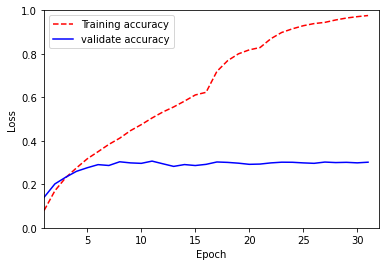

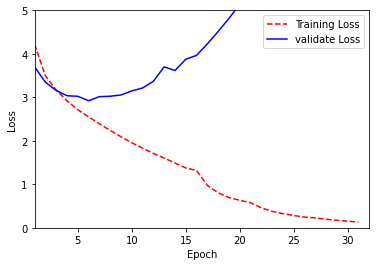


Test accuracy: 0.3066999912261963
Test loss: 3.2151706218719482
0.3066999912261963
0.3066999912261963


In [17]:
#on each epoch the 40K images are diveded into numberOfBatchs
#e.g in case numberOfBatchs=8 every epoch we are running on shuffeled 40000/8=5000 images
# and running with repeatOnEpoch time 
repeatOnEpoch=1
numberOfBatchs=128
lr=0.001
epochs=100
model1, model1_acc =benchmark(build_model_1, lr, epochs)
print(model1_acc)
theModel=model1
theAcc=model1_acc
print(f'Best Accurency is: {theAcc}')

## Run Benchmark: Model 2
1. lr-0.001, 
2. epochs=100
3. numberOfBatchs=128

### Test accuracy: 0.4034999907016754
### Test loss: 3.354229688644409



learning rate 0.001
Epoch 1/100
313/313 [==============================] - 11s 31ms/step - loss: 10.6710 - accuracy: 0.0113 - val_loss: 4.5977 - val_accuracy: 0.0136
Epoch 2/100
313/313 [==============================] - 9s 29ms/step - loss: 4.5111 - accuracy: 0.0229 - val_loss: 4.2871 - val_accuracy: 0.0459
Epoch 3/100
313/313 [==============================] - 9s 29ms/step - loss: 4.1597 - accuracy: 0.0611 - val_loss: 3.9865 - val_accuracy: 0.0850
Epoch 4/100
313/313 [==============================] - 9s 29ms/step - loss: 3.9529 - accuracy: 0.0874 - val_loss: 3.8458 - val_accuracy: 0.1095
Epoch 5/100
313/313 [==============================] - 9s 29ms/step - loss: 3.8093 - accuracy: 0.1133 - val_loss: 3.7315 - val_accuracy: 0.1354
Epoch 6/100
313/313 [==============================] - 9s 29ms/step - loss: 3.6826 - accuracy: 0.1327 - val_loss: 3.6262 - val_accuracy: 0.1483
Epoch 7/100
313/313 [==============================] - 9s 29ms/step - loss: 3.5647 - accuracy: 0.1517 - val_loss: 

Epoch 56/100
313/313 [==============================] - 9s 29ms/step - loss: 0.7993 - accuracy: 0.7599 - val_loss: 3.1714 - val_accuracy: 0.3960
Epoch 57/100
313/313 [==============================] - 9s 29ms/step - loss: 0.7827 - accuracy: 0.7645 - val_loss: 3.1839 - val_accuracy: 0.3926
Epoch 58/100
313/313 [==============================] - 9s 29ms/step - loss: 0.7711 - accuracy: 0.7642 - val_loss: 3.2380 - val_accuracy: 0.3955
Epoch 59/100
313/313 [==============================] - 9s 29ms/step - loss: 0.7638 - accuracy: 0.7666 - val_loss: 3.2442 - val_accuracy: 0.3920
Epoch 60/100
313/313 [==============================] - 9s 29ms/step - loss: 0.7606 - accuracy: 0.7667 - val_loss: 3.2403 - val_accuracy: 0.3931

Epoch 00060: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 61/100
313/313 [==============================] - 9s 29ms/step - loss: 0.7257 - accuracy: 0.7790 - val_loss: 3.2330 - val_accuracy: 0.3955
Epoch 62/100
313/313 [============================

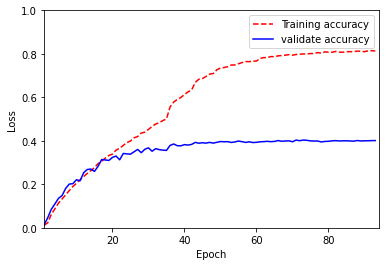

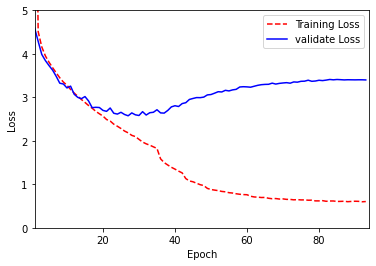


Test accuracy: 0.4034999907016754
Test loss: 3.354229688644409
Best Accurency is: 0.4034999907016754


In [18]:
#on each epoch the 40K images are diveded into numberOfBatchs
#e.g in case numberOfBatchs=8 every epoch we are running on shuffeled 40000/8=5000 images
# and running with repeatOnEpoch time 
repeatOnEpoch=1
numberOfBatchs=128
lr=0.001
epochs=100
model2, model2_acc =benchmark(build_model_2, lr, epochs)
if (model2_acc > theAcc):
    theAcc= model2_acc
    theModel=model2

print(f'Best Accurency is: {theAcc}')

## Run Benchmark: Model 3
1. lr-0.001 with ReduceLROnPlateau 
2. epochs=400 with early stopping
3. numberOfBatchs=400

4. Epoch 00121: ReduceLROnPlateau reducing learning rate to 1e-06.
5. Epoch 00121: early stopping

6. 10000/10000 [==============================] - 44s 4ms/step - loss: 2.7723 - accuracy: 0.4425
Test accuracy: 0.4424999952316284
Test loss: 2.772317409515381

### Test accuracy: 0.4424999952316284
### Test loss: 2.772317409515381



In [19]:
!aws s3 cp ./project3-cifar100-model s3://uatt-e1-dorons/FinalProject3/project3-cifar100-model.ipynb

upload: ./project3-ds-2.4.ipynb to s3://uatt-e1-dorons/FinalProject3/project3-ds-2.4.ipynb


learning rate 0.001
Epoch 1/400
500/500 [==============================] - 16s 30ms/step - loss: 6.1010 - accuracy: 0.0142 - val_loss: 4.4975 - val_accuracy: 0.0201
Epoch 2/400
500/500 [==============================] - 15s 29ms/step - loss: 4.4304 - accuracy: 0.0211 - val_loss: 4.3387 - val_accuracy: 0.0270
Epoch 3/400
500/500 [==============================] - 15s 29ms/step - loss: 4.2625 - accuracy: 0.0323 - val_loss: 4.2364 - val_accuracy: 0.0455
Epoch 4/400
500/500 [==============================] - 15s 29ms/step - loss: 4.1219 - accuracy: 0.0525 - val_loss: 4.1353 - val_accuracy: 0.0680
Epoch 5/400
500/500 [==============================] - 15s 29ms/step - loss: 3.9850 - accuracy: 0.0773 - val_loss: 3.9248 - val_accuracy: 0.0901
Epoch 6/400
500/500 [==============================] - 15s 29ms/step - loss: 3.8239 - accuracy: 0.1036 - val_loss: 3.7260 - val_accuracy: 0.1326
Epoch 7/400
500/500 [==============================] - 15s 30ms/step - loss: 3.6457 - accuracy: 0.1324 - val_l

500/500 [==============================] - 14s 29ms/step - loss: 1.7560 - accuracy: 0.5259 - val_loss: 2.4506 - val_accuracy: 0.4118
Epoch 58/400
500/500 [==============================] - 15s 29ms/step - loss: 1.6672 - accuracy: 0.5496 - val_loss: 2.4153 - val_accuracy: 0.4212
Epoch 59/400
500/500 [==============================] - 14s 29ms/step - loss: 1.6237 - accuracy: 0.5562 - val_loss: 2.4771 - val_accuracy: 0.4170
Epoch 60/400
500/500 [==============================] - 15s 29ms/step - loss: 1.5805 - accuracy: 0.5696 - val_loss: 2.4727 - val_accuracy: 0.4170
Epoch 61/400
500/500 [==============================] - 15s 29ms/step - loss: 1.5724 - accuracy: 0.5688 - val_loss: 2.5198 - val_accuracy: 0.4143
Epoch 62/400
500/500 [==============================] - 15s 29ms/step - loss: 1.5330 - accuracy: 0.5781 - val_loss: 2.4830 - val_accuracy: 0.4231
Epoch 63/400
500/500 [==============================] - 15s 29ms/step - loss: 1.5111 - accuracy: 0.5851 - val_loss: 2.4954 - val_accuracy

Epoch 110/400
500/500 [==============================] - 15s 29ms/step - loss: 0.8550 - accuracy: 0.7481 - val_loss: 2.7823 - val_accuracy: 0.4404
Epoch 111/400
500/500 [==============================] - 15s 29ms/step - loss: 0.8510 - accuracy: 0.7468 - val_loss: 2.7895 - val_accuracy: 0.4410

Epoch 00111: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 112/400
500/500 [==============================] - 15s 30ms/step - loss: 0.8489 - accuracy: 0.7458 - val_loss: 2.7892 - val_accuracy: 0.4412
Epoch 113/400
500/500 [==============================] - 15s 29ms/step - loss: 0.8470 - accuracy: 0.7485 - val_loss: 2.7902 - val_accuracy: 0.4412
Epoch 114/400
500/500 [==============================] - 14s 29ms/step - loss: 0.8484 - accuracy: 0.7466 - val_loss: 2.7911 - val_accuracy: 0.4404
Epoch 115/400
500/500 [==============================] - 15s 29ms/step - loss: 0.8490 - accuracy: 0.7482 - val_loss: 2.7895 - val_accuracy: 0.4418
Epoch 116/400
500/500 [==============

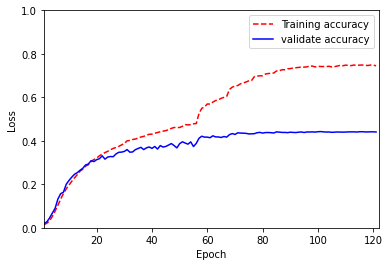

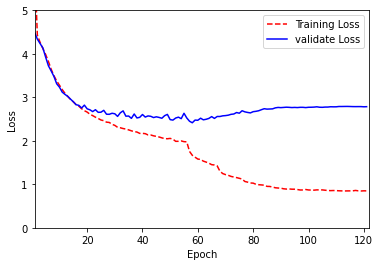


Test accuracy: 0.4424999952316284
Test loss: 2.772317409515381
0.4424999952316284


In [20]:
#on each epoch the 40K images are diveded into numberOfBatchs
#e.g in case numberOfBatchs=8 every epoch we are running on shuffeled 40000/8=5000 images
# and running with repeatOnEpoch time 
repeatOnEpoch=1
numberOfBatchs=80
lr=0.001
epochs=400
model3, model3_acc =benchmark(build_model_3, lr, epochs)

if (model3_acc > theAcc):
    theAcc= model3_acc
    theModel=model3

print(theAcc)

In [21]:
!aws s3 cp ./project3-cifar100-model s3://uatt-e1-dorons/FinalProject3/project3-cifar100-model.ipynb

upload: ./project3-ds-2.4.ipynb to s3://uatt-e1-dorons/FinalProject3/project3-ds-2.4.ipynb


## Run Benchmark: Model vgg19 - Bad results
(it looks like vgg19 architecture doesn't suitable for CIFAR 100 images with 32*32*3 size)
1. lr-0.001 with ReduceLROnPlateau 
2. epochs=800 with early stopping
3. numberOfBatchs=400

4. Epoch 00021: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
5. Epoch 00021: early stopping
6. 10000/10000 [==============================] - 144s 14ms/step - loss: 4.6052 - accuracy: 0.0100



#### Test accuracy: 0.009999999776482582 :(
#### Test loss: 4.605218887329102



learning rate 0.001
Epoch 1/800
500/500 [==============================] - 65s 124ms/step - loss: 4.7503 - accuracy: 0.0097 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 2/800
500/500 [==============================] - 61s 123ms/step - loss: 4.6058 - accuracy: 0.0094 - val_loss: 4.6053 - val_accuracy: 0.0100
Epoch 3/800
500/500 [==============================] - 61s 123ms/step - loss: 4.6056 - accuracy: 0.0096 - val_loss: 4.6054 - val_accuracy: 0.0100
Epoch 4/800
500/500 [==============================] - 61s 122ms/step - loss: 4.6072 - accuracy: 0.0094 - val_loss: 4.6055 - val_accuracy: 0.0100
Epoch 5/800
500/500 [==============================] - 61s 122ms/step - loss: 4.6056 - accuracy: 0.0095 - val_loss: 4.6054 - val_accuracy: 0.0100
Epoch 6/800
500/500 [==============================] - 61s 122ms/step - loss: 4.6056 - accuracy: 0.0095 - val_loss: 4.6055 - val_accuracy: 0.0100

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/800
500/500 [==

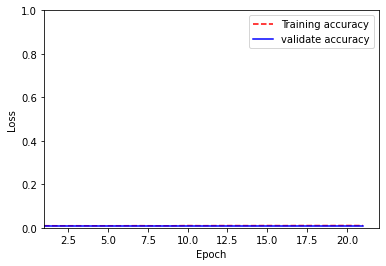

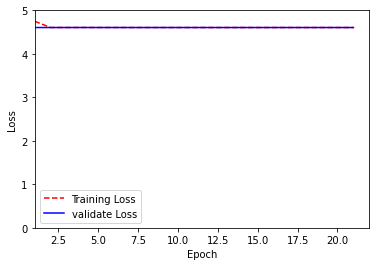


Test accuracy: 0.009999999776482582
Test loss: 4.605218887329102
Best Accurency is: 0.4424999952316284


In [22]:
#on each epoch the 40K images are diveded into numberOfBatchs
#e.g in case numberOfBatchs=8 every epoch we are running on shuffeled 40000/8=5000 images
# and running with repeatOnEpoch time 
repeatOnEpoch=1
numberOfBatchs=80
lr=0.001
epochs=800

model_vgg19, model_vgg19_acc =benchmark(build_model_vgg19, lr, epochs)
if (model_vgg19_acc > theAcc):
    theAcc= model_vgg19_acc
    theModel=model_vgg19

print(f'Best Accurency is: {theAcc}')

In [38]:
!aws s3 cp ./project3-cifar100-model s3://uatt-e1-dorons/FinalProject3/project3-cifar100-model.ipynb


The user-provided path ./project3-ds-2.2.ipynb does not exist.


## Save the best model: Mode 3

In [23]:

# Save the entire model as a SavedModel.
!mkdir -p saved_model
theModel.save('saved_model/ds_cifar100.4_model')

INFO:tensorflow:Assets written to: saved_model/ds2.4_model/assets


INFO:tensorflow:Assets written to: saved_model/ds2.4_model/assets
